<a href="https://colab.research.google.com/github/tech-dhawal-03/Data-Mining-Projects/blob/main/Healthcare_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
import pandas as pd
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [26]:
# Load dataset
def load_data():
    beneficiary = pd.read_csv('/Beneficiary.csv')
    inpatient = pd.read_csv('/Inpatient.csv')
    outpatient = pd.read_csv('/Outpatient.csv')

    return beneficiary, inpatient, outpatient

load_data()


(            BeneID         DOB  DOD  Gender  Race RenalDiseaseIndicator  \
 0        BENE11001  1943-01-01  NaN       1     1                     0   
 1        BENE11002  1936-09-01  NaN       2     1                     0   
 2        BENE11003  1936-08-01  NaN       1     1                     0   
 3        BENE11004  1922-07-01  NaN       1     1                     0   
 4        BENE11005  1935-09-01  NaN       1     1                     0   
 ...            ...         ...  ...     ...   ...                   ...   
 138551  BENE159194  1939-07-01  NaN       1     1                     0   
 138552  BENE159195  1938-12-01  NaN       2     1                     0   
 138553  BENE159196  1916-06-01  NaN       2     1                     0   
 138554  BENE159197  1930-01-01  NaN       1     1                     0   
 138555  BENE159198  1952-04-01  NaN       2     1                     0   
 
         State  County  NoOfMonths_PartACov  NoOfMonths_PartBCov  ...  \
 0          3

In [31]:
def preprocess_data(beneficiary, inpatient, outpatient, fraudulent_providers=None):
    # Merge datasets
    inpatient_merged = pd.merge(inpatient, beneficiary, on='BeneID', how='inner')
    outpatient_merged = pd.merge(outpatient, beneficiary, on='BeneID', how='inner')

    # Feature Engineering for Inpatient data
    inpatient_features = create_inpatient_features(inpatient_merged)

    # Feature Engineering for Outpatient data
    outpatient_features = create_outpatient_features(outpatient_merged)

    # Merge feature sets
    provider_features = pd.merge(inpatient_features, outpatient_features, on='Provider', how='outer').fillna(0)

    # Create fraud labels
    if fraudulent_providers is not None:
        # If you have a list of fraudulent providers
        provider_features['PotentialFraud'] = provider_features['Provider'].isin(fraudulent_providers).astype(int)
    else:
        # If fraud labels should come from somewhere else, add the logic here
        # For demonstration, we'll label providers with unusually high claim amounts as potentially fraudulent
        threshold_in = provider_features['InPatAvgClaimAmount'].mean() + 2 * provider_features['InPatAvgClaimAmount'].std()
        threshold_out = provider_features['OutPatAvgClaimAmount'].mean() + 2 * provider_features['OutPatAvgClaimAmount'].std()

        provider_features['PotentialFraud'] = ((provider_features['InPatAvgClaimAmount'] > threshold_in) |
                                               (provider_features['OutPatAvgClaimAmount'] > threshold_out)).astype(int)

    return provider_features

In [29]:
def create_inpatient_features(df):
    # Group by provider
    provider_groups = df.groupby('Provider')

    # Calculate features using the available columns
    total_claims = provider_groups.size()
    avg_claim_amt = provider_groups['InscClaimAmtReimbursed'].mean()
    std_claim_amt = provider_groups['InscClaimAmtReimbursed'].std().fillna(0)

    # Calculate length of stay for inpatient (difference between ClaimEndDt and ClaimStartDt)
    df['StayLength'] = (pd.to_datetime(df['ClaimEndDt']) - pd.to_datetime(df['ClaimStartDt'])).dt.days + 1
    avg_stay_length = provider_groups['StayLength'].mean()

    # Check if diagnosis and procedure columns are available
    diag_cols = [col for col in df.columns if 'ClmDiagnosisCode' in col]
    proc_cols = [col for col in df.columns if 'ClmProcedureCode' in col]

    # Create a dataframe of features
    features = pd.DataFrame({
        'Provider': avg_claim_amt.index,
        'InPatTotalClaims': total_claims.values,
        'InPatAvgClaimAmount': avg_claim_amt.values,
        'InPatStdClaimAmount': std_claim_amt.values,
        'InPatAvgStayLength': avg_stay_length.values
    })

    # Count unique diagnoses and procedures
    if diag_cols:
        unique_diags = df.groupby('Provider')[diag_cols].nunique().sum(axis=1)
        features['InPatUniqueDiagnoses'] = unique_diags.values

    if proc_cols:
        unique_procs = df.groupby('Provider')[proc_cols].nunique().sum(axis=1)
        features['InPatUniqueProcedures'] = unique_procs.values

    # Count unique patients
    unique_patients = provider_groups['BeneID'].nunique()
    features['InPatUniquePatients'] = unique_patients.values

    return features

In [30]:
def create_outpatient_features(df):
    # Group by provider
    provider_groups = df.groupby('Provider')

    # Calculate features using the available columns
    total_claims = provider_groups.size()
    avg_claim_amt = provider_groups['InscClaimAmtReimbursed'].mean()
    std_claim_amt = provider_groups['InscClaimAmtReimbursed'].std().fillna(0)

    # Check if diagnosis and procedure columns are available
    diag_cols = [col for col in df.columns if 'ClmDiagnosisCode' in col]
    proc_cols = [col for col in df.columns if 'ClmProcedureCode' in col]

    # Create a dataframe of features
    features = pd.DataFrame({
        'Provider': avg_claim_amt.index,
        'OutPatTotalClaims': total_claims.values,
        'OutPatAvgClaimAmount': avg_claim_amt.values,
        'OutPatStdClaimAmount': std_claim_amt.values
    })

    # Use DeductibleAmtPaid if available
    if 'DeductibleAmtPaid' in df.columns:
        avg_deductible = provider_groups['DeductibleAmtPaid'].mean()
        features['OutPatAvgDeductible'] = avg_deductible.values

    # Count unique diagnoses and procedures
    if diag_cols:
        unique_diags = df.groupby('Provider')[diag_cols].nunique().sum(axis=1)
        features['OutPatUniqueDiagnoses'] = unique_diags.values

    if proc_cols:
        unique_procs = df.groupby('Provider')[proc_cols].nunique().sum(axis=1)
        features['OutPatUniqueProcedures'] = unique_procs.values

    # Count unique patients
    unique_patients = provider_groups['BeneID'].nunique()
    features['OutPatUniquePatients'] = unique_patients.values

    return features


In [16]:
def train_model(data):
    # Separate features and target
    X = data.drop(['Provider', 'PotentialFraud'], axis=1)
    y = data['PotentialFraud']

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Apply SMOTE for handling class imbalance
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

    # Train Random Forest model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train_resampled, y_train_resampled)

    # Train Gradient Boosting model
    gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
    gb_model.fit(X_train_resampled, y_train_resampled)

    return rf_model, gb_model, X_test_scaled, y_test, scaler


In [17]:
def evaluate_model(model, X_test, y_test, model_name):
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Print metrics
    print(f"{model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.savefig(f'{model_name}_roc_curve.png')

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.savefig(f'{model_name}_confusion_matrix.png')

    return accuracy, precision, recall, f1, roc_auc

In [18]:
def feature_importance(model, X, model_name):
    # Get feature importance
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]

        # Plot feature importance
        plt.figure(figsize=(10, 8))
        plt.title(f'Feature Importance - {model_name}')
        plt.bar(range(X.shape[1]), importances[indices])
        plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
        plt.tight_layout()
        plt.savefig(f'{model_name}_feature_importance.png')

        # Print top 10 features
        print(f"\nTop 10 Important Features for {model_name}:")
        for i in range(min(10, X.shape[1])):
            print(f"{i+1}. {X.columns[indices[i]]} - {importances[indices[i]]:.4f}")

In [19]:
def detect_fraud(model, scaler, provider_data, threshold=0.7):
    # Preprocess new data
    provider_features = provider_data.drop(['Provider'], axis=1, errors='ignore')

    # Scale features
    provider_features_scaled = scaler.transform(provider_features)

    # Get probability predictions
    fraud_proba = model.predict_proba(provider_features_scaled)[:, 1]

    # Add predictions to original data
    provider_data['FraudProbability'] = fraud_proba
    provider_data['FraudFlag'] = (fraud_proba >= threshold).astype(int)

    # Sort by fraud probability
    result = provider_data.sort_values('FraudProbability', ascending=False)

    return result

Loading datasets...
Preprocessing data...
Training models...

Evaluating Random Forest model...
Random Forest Results:
Accuracy: 0.9982
Precision: 0.9821
Recall: 0.9649
F1 Score: 0.9735

Evaluating Gradient Boosting model...
Gradient Boosting Results:
Accuracy: 0.9994
Precision: 0.9828
Recall: 1.0000
F1 Score: 0.9913

Analyzing feature importance...

Top 10 Important Features for Random Forest:
1. InPatAvgClaimAmount - 0.4778
2. InPatStdClaimAmount - 0.1202
3. InPatUniqueProcedures - 0.1054
4. InPatTotalClaims - 0.0859
5. InPatUniquePatients - 0.0677
6. InPatUniqueDiagnoses - 0.0601
7. InPatAvgStayLength - 0.0524
8. OutPatAvgClaimAmount - 0.0121
9. OutPatUniquePatients - 0.0046
10. OutPatStdClaimAmount - 0.0045

Top 10 Important Features for Gradient Boosting:
1. InPatAvgClaimAmount - 0.9735
2. OutPatAvgClaimAmount - 0.0242
3. InPatTotalClaims - 0.0005
4. InPatUniqueProcedures - 0.0004
5. OutPatTotalClaims - 0.0004
6. OutPatUniqueDiagnoses - 0.0004
7. InPatUniquePatients - 0.0003
8. Ou

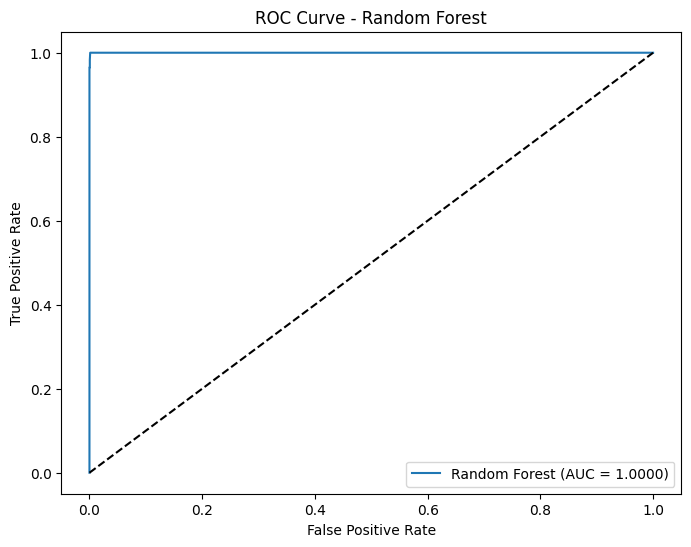

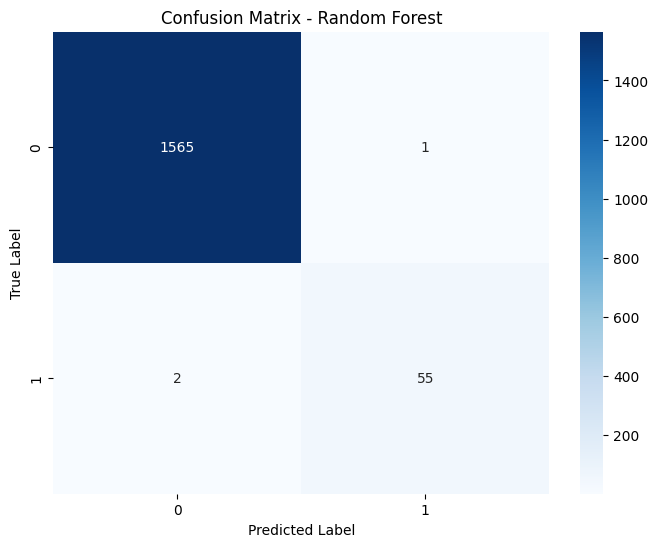

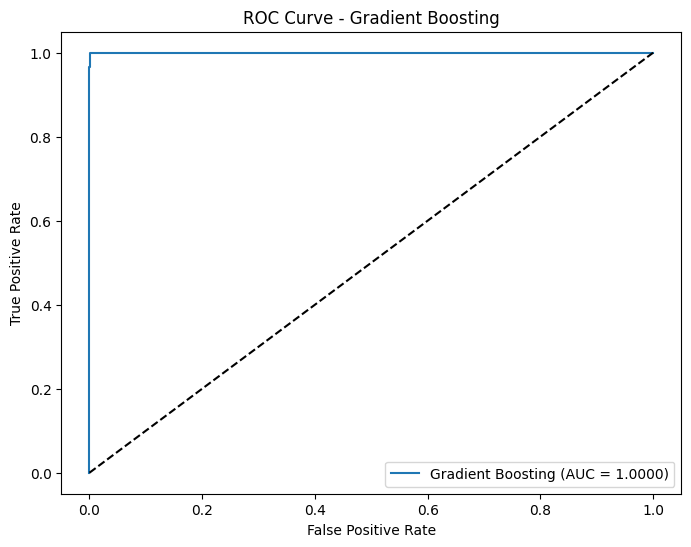

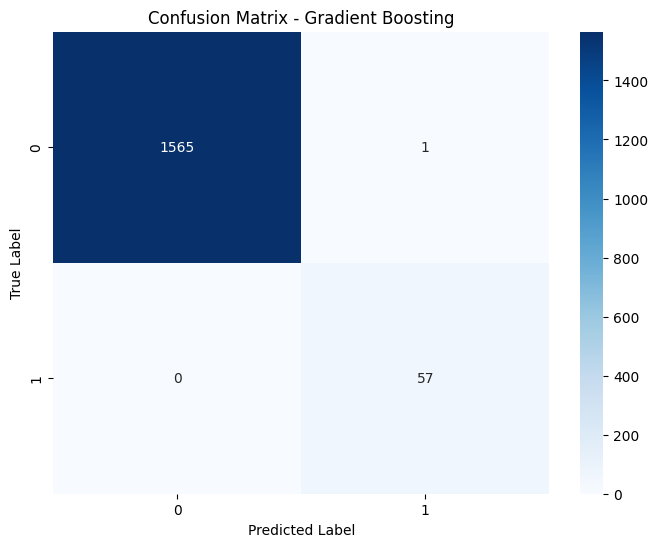

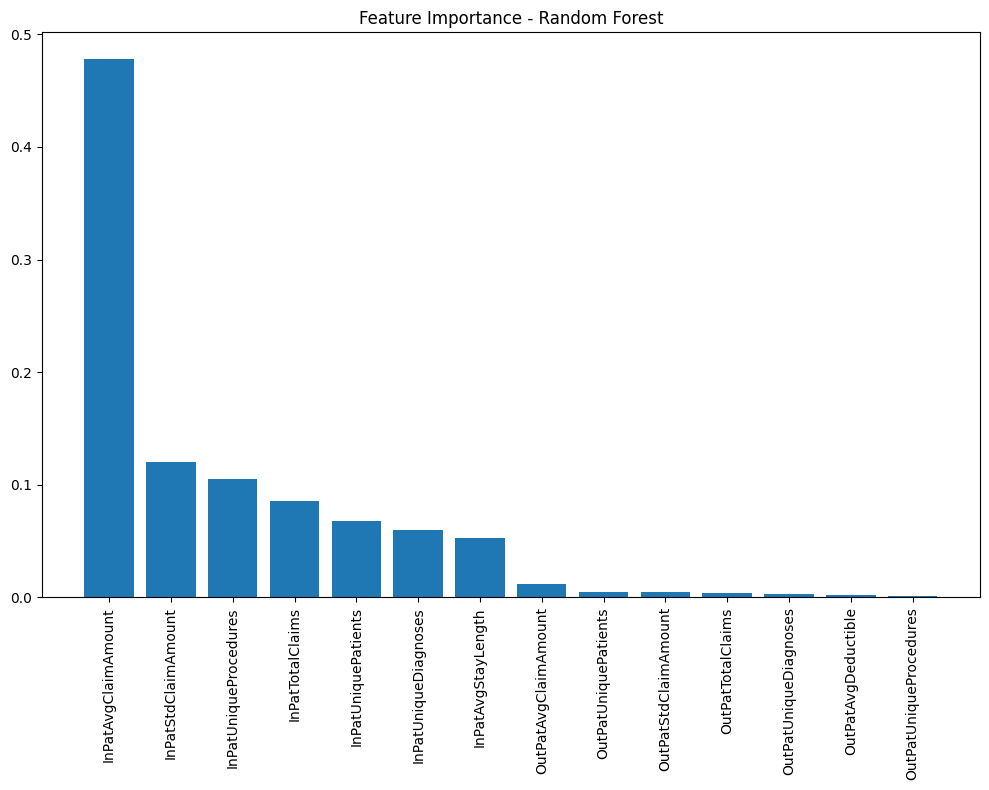

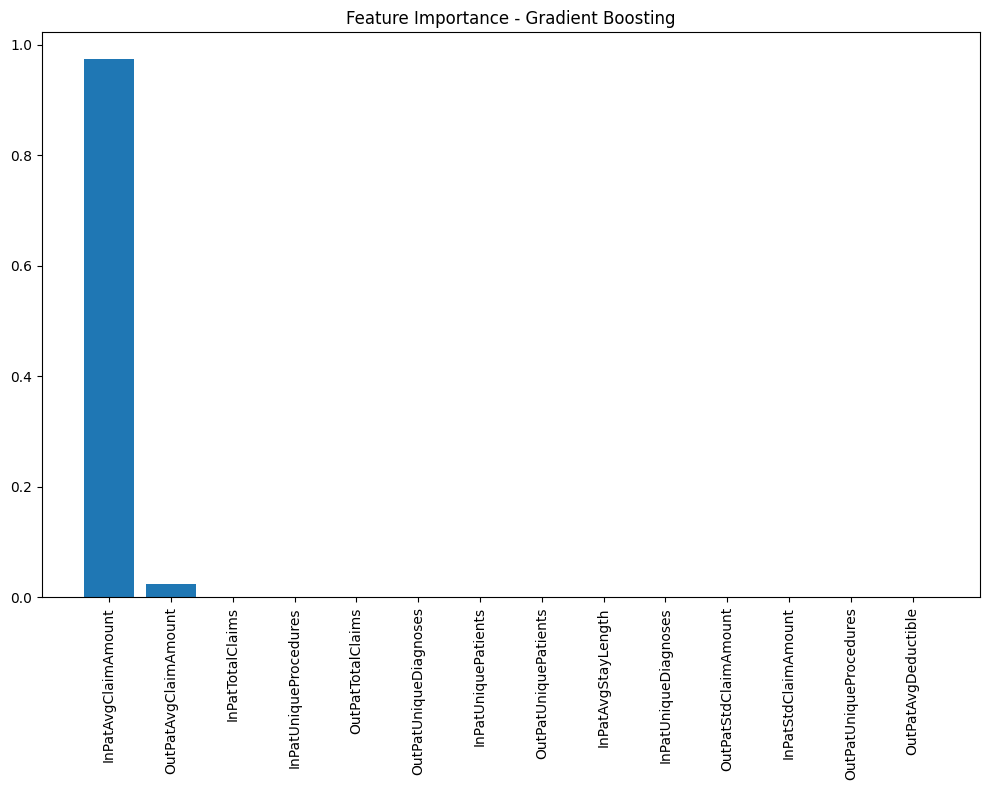

In [44]:
def main():
    print("Loading datasets...")
    try:
        beneficiary, inpatient, outpatient = load_data()
    except FileNotFoundError:
        print("Error: Dataset files not found.")
        print("Please download the Healthcare Provider Fraud Detection Analysis dataset from Kaggle:")
        print("https://www.kaggle.com/datasets/rohitrox/healthcare-provider-fraud-detection-analysis")
        print("Extract the files and ensure Beneficiary.csv, Inpatient.csv, and Outpatient.csv are in the working directory.")
        return

    print("Preprocessing data...")
    final_data = preprocess_data(beneficiary, inpatient, outpatient)

    print("Training models...")
    rf_model, gb_model, X_test, y_test, scaler = train_model(final_data)

    print("\nEvaluating Random Forest model...")
    evaluate_model(rf_model, X_test, y_test, "Random Forest")

    print("\nEvaluating Gradient Boosting model...")
    evaluate_model(gb_model, X_test, y_test, "Gradient Boosting")

    print("\nAnalyzing feature importance...")
    X = final_data.drop(['Provider', 'PotentialFraud'], axis=1)
    feature_importance(rf_model, X, "Random Forest")
    feature_importance(gb_model, X, "Gradient Boosting")

    print("\nSaving models...")
    import joblib
    joblib.dump(rf_model, 'rf_fraud_detection_model.pkl')
    joblib.dump(gb_model, 'gb_fraud_detection_model.pkl')
    joblib.dump(scaler, 'scaler.pkl')

    print("\nHealthcare fraud detection models have been successfully trained and evaluated.")
    print("The models are saved as 'rf_fraud_detection_model.pkl' and 'gb_fraud_detection_model.pkl'.")
    print("Use detect_fraud() function to apply the model to new provider data.")

if __name__ == "__main__":
    main()
